## Import data from file
To facilitate a fast training, we use user4 as the only input data

Here, the data has 6 gestures with each gestures contains 750 samples and total 4500 samples

Each file contains data size of packet number \*30 subcarrier\*3 Reciver \*1 Transmitter

We regulate the packets number to 1500, and the processed data shape is : (4500, 1500, 30, 3, 1)

In [1]:
import os
import re
import numpy as np
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
import csiread

def pad_or_truncate_sequence(sequence, max_len, padding_value=0):
    """Pad or truncate a sequence to max_len."""
    if len(sequence) > max_len:
        return sequence[:max_len]
    else:
        pad_width = ((0, max_len - len(sequence)), (0, 0), (0, 0), (0, 0))
        return np.pad(sequence, pad_width, mode='constant', constant_values=padding_value)

def prepare_data(folder_path, max_sequence_length=500):
    """
    Load and preprocess CSI data from files.
    Args:
        folder_path: Path to folder containing CSI data files
        max_sequence_length: Maximum length of time sequence to pad/truncate to
    """
    # Group files by gesture
    groups = defaultdict(list)
    pattern = re.compile(r'user\d+-(\d)-\d-\d-\d-r\d\.dat', re.IGNORECASE)
    
    for filename in os.listdir(folder_path):
        match = pattern.match(filename)
        if match:
            gesture_id = int(match.group(1))
            groups[gesture_id].append(filename)

    all_sequences = []
    all_labels = []

    # Process each file
    for gesture_id in sorted(groups.keys()):
        for csifile in groups[gesture_id]:
            file_path = os.path.join(folder_path, csifile)
            
            # Load CSI data
            csidata = csiread.Intel(file_path, nrxnum=3, ntxnum=1, pl_size=10)
            csidata.read()
            csi = csidata.get_scaled_csi()
            
            # Normalize the sequence
            csi = (csi - np.mean(csi)) / (np.std(csi) + 1e-8)
            
            # Pad or truncate sequence
            processed_sequence = pad_or_truncate_sequence(csi, max_sequence_length)
            
            all_sequences.append(processed_sequence)
            all_labels.append(gesture_id)
    
    # Convert to numpy arrays with consistent shapes
    X = np.array(all_sequences)
    y = np.array(all_labels)
    y=y-1
    
    print(f"Processed data shape: {X.shape}")
    print(f"Number of classes: {len(np.unique(y))}")
    print(f"Samples per class: {np.bincount(y)}")
    
    return X, y

class GestureDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def create_data_loaders(X, y, batch_size=32, test_split=0.2):
    """
    Create train and test data loaders.
    """
    from sklearn.model_selection import train_test_split
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_split, stratify=y, random_state=42
    )
    
    # Create datasets
    train_dataset = GestureDataset(X_train, y_train)
    test_dataset = GestureDataset(X_test, y_test)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Load and preprocess data
X, y = prepare_data('./user4', max_sequence_length=1500)  # Adjust max_sequence_length as needed


connector_log=0x1
1440 0xbb packets parsed
connector_log=0x1
1458 0xbb packets parsed
connector_log=0x1
1502 0xbb packets parsed
connector_log=0x1
1524 0xbb packets parsed
connector_log=0x1
1410 0xbb packets parsed
connector_log=0x1
1407 0xbb packets parsed
connector_log=0x1
1467 0xbb packets parsed
connector_log=0x1
1368 0xbb packets parsed
connector_log=0x1
1489 0xbb packets parsed
connector_log=0x1
1463 0xbb packets parsed
connector_log=0x1
1384 0xbb packets parsed
connector_log=0x1
1490 0xbb packets parsed
connector_log=0x1
1443 0xbb packets parsed
connector_log=0x1
1618 0xbb packets parsed
connector_log=0x1
1459 0xbb packets parsed
connector_log=0x1
1400 0xbb packets parsed
connector_log=0x1
1390 0xbb packets parsed
connector_log=0x1
1378 0xbb packets parsed
connector_log=0x1
1462 0xbb packets parsed
connector_log=0x1
1274 0xbb packets parsed
connector_log=0x1
1461 0xbb packets parsed
connector_log=0x1
1302 0xbb packets parsed
connector_log=0x1
1451 0xbb packets parsed
connector_l

## Reshape the data for model taining

In [2]:
real_data = np.abs(X.transpose(0, 3, 2, 1, 4).reshape(-1, 3, 30, 1500))
complex_data = X.transpose(0, 3, 2, 1, 4).reshape(-1, 3, 30, 1500)



In [3]:
real_vector = X.real
real_vector.shape

(4500, 1500, 30, 3, 1)

In [4]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pykalman import KalmanFilter


class CSIProcessor:
    def __init__(self, data):
        """
        Initialize the CSIProcessor class.
        :param data: numpy array of CSI data with shape (samples, packets, subcarriers, rx, tx)
        """
        self.data = data
        self.filtered_data = None
        self.processed_data = None

    def extract_magnitude(self):
        """
        Extract magnitude from complex CSI data.
        """
        self.data = np.abs(self.data)

    def standardize(self, method="z-score"):
        """
        Standardize the data using the specified method.
        :param method: "z-score" or "min-max"
        """
        if method == "z-score":
            scaler = StandardScaler()
        elif method == "min-max":
            scaler = MinMaxScaler()
        else:
            raise ValueError("Standardization method must be 'z-score' or 'min-max'")
        
        original_shape = self.data.shape
        reshaped_data = self.data.reshape(-1, original_shape[-1])
        standardized_data = scaler.fit_transform(reshaped_data)
        self.data = standardized_data.reshape(original_shape)

    @staticmethod
    def butterworth_filter(data, cutoff, fs, order=5):
        """
        Apply a low-pass Butterworth filter.
        :param data: Data to be filtered.
        :param cutoff: Cutoff frequency.
        :param fs: Sampling frequency.
        :param order: Order of the Butterworth filter.
        :return: Filtered data.
        """
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data, axis=0)

    @staticmethod
    def gaussian_filter(data, sigma):
        """
        Apply Gaussian filter for noise reduction.
        :param data: Data to be filtered.
        :param sigma: Standard deviation for Gaussian kernel.
        :return: Filtered data.
        """
        return gaussian_filter(data, sigma=sigma)

    @staticmethod
    def kalman_filter(data):
        original_shape = data.shape
        reshaped_data = data.reshape(-1, data.shape[-1])
        kf = KalmanFilter(initial_state_mean=np.mean(reshaped_data, axis=0), n_dim_obs=reshaped_data.shape[1])
        kf = kf.em(reshaped_data, n_iter=10)
        filtered_states, _ = kf.filter(reshaped_data)
        filtered_data = filtered_states.reshape(original_shape)
        return filtered_data
    


    def apply_filter(self, filter_type, **kwargs):
        """
        Apply a selected filter to the data.
        :param filter_type: Filter to apply ("butterworth", "gaussian", "kalman", "fft", "moving_average").
        :param kwargs: Parameters for the selected filter.
        """
        if filter_type == "butterworth":
            self.filtered_data = self.butterworth_filter(self.data, **kwargs)
        elif filter_type == "gaussian":
            self.filtered_data = self.gaussian_filter(self.data, **kwargs)
        elif filter_type == "kalman":
            self.filtered_data = self.kalman_filter(self.data)
        else:
            raise ValueError("Invalid filter type. Choose from 'butterworth', 'gaussian', 'kalman', 'fft', or 'moving_average'.")

    def process(self, filter_type, standardization_method="z-score", **kwargs):
        """
        Run the full preprocessing pipeline.
        :param filter_type: Filter to apply ("butterworth", "gaussian", "kalman", "fft", "moving_average").
        :param standardization_method: Method to standardize data ("z-score" or "min-max").
        :param kwargs: Additional parameters for filtering.
        """
        print("Extracting magnitude...")
        self.extract_magnitude()

        print(f"Applying {filter_type} filter...")
        self.apply_filter(filter_type, **kwargs)

        print(f"Standardizing data with {standardization_method}...")
        self.standardize(method=standardization_method)

        print("Processing complete.")
        self.processed_data = self.filtered_data
        return self.processed_data


ModuleNotFoundError: No module named 'pykalman'

In [ ]:
# Initialize the processor
processor = CSIProcessor(data=real_vector)

# Apply Butterworth filter and standardize
processed_data_butterworth = processor.process(
    filter_type="butterworth",
    cutoff=2.0,
    fs=20,
    order=5,
    standardization_method="z-score"
)

Extracting magnitude...
Applying butterworth filter...
Standardizing data with z-score...
Processing complete.


In [ ]:
print(processed_data_butterworth.shape)
processed_data_butterworth = processed_data_butterworth.transpose(0, 3, 2, 1, 4).reshape(-1, 3, 30, 1500)
processed_data_butterworth.shape

(4500, 1500, 30, 3, 1)


(4500, 3, 30, 1500)

## Model training process
### We utilize Resnet for model training

filtered CSI data ....
Using device: mps
Epoch [1/10]
Train Loss: 1.0218 Train Acc: 54.30%
Val Loss: 2.3066 Val Acc: 46.22%
Epoch [2/10]
Train Loss: 0.6793 Train Acc: 70.74%
Val Loss: 0.7555 Val Acc: 61.67%
Epoch [3/10]
Train Loss: 0.5604 Train Acc: 76.07%
Val Loss: 0.6209 Val Acc: 74.56%
Epoch [4/10]
Train Loss: 0.4781 Train Acc: 79.11%
Val Loss: 1.0804 Val Acc: 56.89%
Epoch [5/10]
Train Loss: 0.3439 Train Acc: 85.96%
Val Loss: 0.6667 Val Acc: 73.33%
Epoch [6/10]
Train Loss: 0.2606 Train Acc: 89.56%
Val Loss: 1.2178 Val Acc: 68.78%
Epoch [7/10]
Train Loss: 0.2703 Train Acc: 88.70%
Val Loss: 1.5340 Val Acc: 63.33%
Epoch [8/10]
Train Loss: 0.1945 Train Acc: 92.48%
Val Loss: 1.1116 Val Acc: 67.22%
Epoch [9/10]
Train Loss: 0.1959 Train Acc: 92.78%
Val Loss: 3.3086 Val Acc: 47.78%
Epoch [10/10]
Train Loss: 0.1566 Train Acc: 94.59%
Val Loss: 0.3218 Val Acc: 88.44%

Evaluating model on test set:

Classification Report:
              precision    recall  f1-score   support

     Class_0      

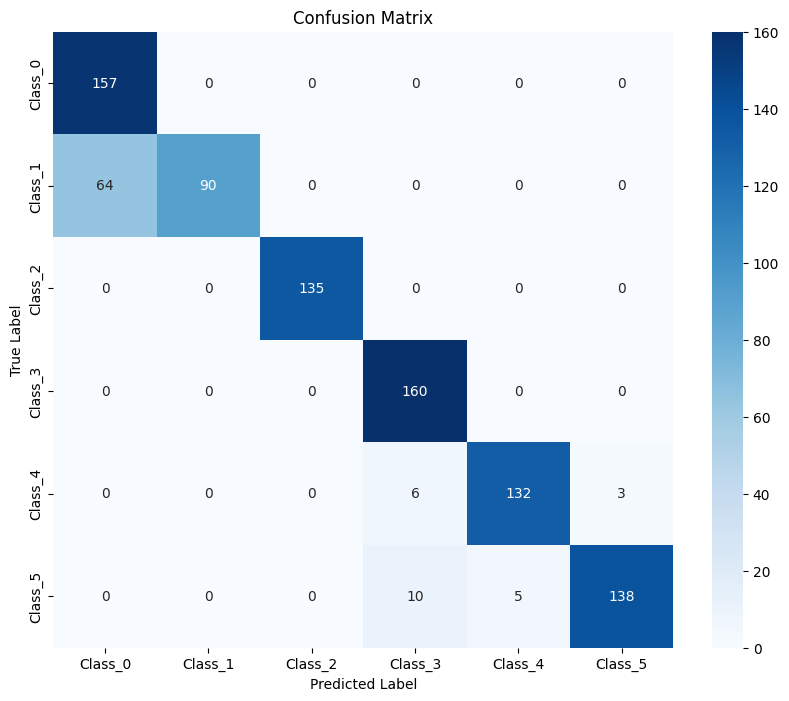

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


class CSIDataset(Dataset):
    def __init__(self, signals, labels):
        """
        signals: numpy array of shape (N, 3, 30, 1500)
        labels: numpy array of shape (N,)
        """
        self.signals = torch.FloatTensor(signals)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out


class CSIResNet(nn.Module):
    def __init__(self, num_classes):
        super(CSIResNet, self).__init__()
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        
    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    best_acc = 0.0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            acc = predicted.eq(labels).sum().item() / labels.size(0)
            
            train_loss.update(loss.item(), inputs.size(0))
            train_acc.update(acc, inputs.size(0))
        
        # Validation phase
        val_loss, val_acc = test_model(model, val_loader, criterion, device)
        
        train_losses.append(train_loss.avg)
        val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss.avg:.4f} Train Acc: {train_acc.avg*100:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc*100:.2f}%')
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return train_losses, val_losses

def test_model(model, test_loader, criterion, device):
    """
    Test the model and return loss and accuracy
    """
    model.eval()
    test_loss = AverageMeter()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss.update(loss.item(), inputs.size(0))
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    return test_loss.avg, accuracy

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot confusion matrix using seaborn
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model(model, test_loader, device, class_names):
    """
    Comprehensive model evaluation
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)

def main():
    # Hyperparameters
    num_classes = 6  
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 10
    
    # Device configuration
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f'Using device: {device}')
        
    # Create dataset and dataloader
    # Split the data into train validation and test sets
    #Raw CSI data 
    X_train, X_test, y_train, y_test = train_test_split(transposed_data, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


    # Create datasets and dataloaders
    train_dataset = CSIDataset(X_train, y_train)
    test_dataset = CSIDataset(X_test, y_test)
    val_dataset = CSIDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    
    # Initialize model, criterion, and optimizer
    model = CSIResNet(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Class names (replace with your actual class names)
    class_names = [f'Class_{i}' for i in range(num_classes)]

    # Train the model
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)
    
    # Save the model
    torch.save(model.state_dict(), 'csi_resnet_model.pth')

    # Evaluate model
    print("\nEvaluating model on test set:")
    evaluate_model(model, test_loader, device, class_names)

if __name__ == '__main__':
    # print("abs CSI data starting....")
    # transposed_data = real_data
    # main()
    print("filtered CSI data ....")
    transposed_data = processed_data_butterworth
    main()


## Enhance the Resnet model to improve performance

This time we apply deeper network with more layers:

Added a fourth residual layer (layer4) and increased number of blocks in each layer


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
from datetime import datetime

class CSIDataset(Dataset):
    def __init__(self, signals, labels):
        """
        signals: numpy array of shape (N, 3, 30, 1500)
        labels: numpy array of shape (N,)
        """
        self.signals = torch.FloatTensor(signals)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out

class ResidualBlock2(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Dropout for regularization
        self.dropout = nn.Dropout2d(0.1)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out
    
class CSIResNet(nn.Module):
    def __init__(self, num_classes):
        super(CSIResNet, self).__init__()
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        
    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

## More deeper network
class CSIResNet2(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CSIResNet2, self).__init__()
        
        # Initial convolution layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Residual layers with increased depth
        self.layer1 = self.make_layer(64, 64, 3, stride=1)
        self.layer2 = self.make_layer(64, 128, 4, stride=2)
        self.layer3 = self.make_layer(128, 256, 6, stride=2)
        self.layer4 = self.make_layer(256, 512, 3, stride=2)
        
        # Global average pooling and final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock2(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock2(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class MixupAugmentation:
    def __init__(self, alpha=0.2):
        self.alpha = alpha
    
    def __call__(self, x, y):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = x.size(0)
        index = torch.randperm(batch_size).to(x.device)

        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam


def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    best_acc = 0.0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            acc = predicted.eq(labels).sum().item() / labels.size(0)
            
            train_loss.update(loss.item(), inputs.size(0))
            train_acc.update(acc, inputs.size(0))
        
        # Validation phase
        val_loss, val_acc = test_model(model, val_loader, criterion, device)
        
        train_losses.append(train_loss.avg)
        val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss.avg:.4f} Train Acc: {train_acc.avg*100:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc*100:.2f}%')
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model_new.pth')
    
    return train_losses, val_losses

def train_model2(model, train_loader, val_loader, criterion, optimizer, scheduler, device, mixup, num_epochs=10):
    best_acc = 0.0
    patience = 10
    patience_counter = 0

    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

             # Apply mixup
            inputs, targets_a, targets_b, lam = mixup(inputs, labels)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            
            _, predicted = outputs.max(1)
            acc = (lam * predicted.eq(targets_a).float() + (1 - lam) * predicted.eq(targets_b).float()).mean()
            
            train_loss.update(loss.item(), inputs.size(0))
            train_acc.update(acc, inputs.size(0))

               
        
        # Validation phase
        val_loss, val_acc = test_model(model, val_loader, criterion, device)
        
        train_losses.append(train_loss.avg)
        val_losses.append(val_loss)
        
        # Early stopping check
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
            }, 'best_model_new.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        

        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss.avg:.4f} Train Acc: {train_acc.avg*100:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc*100:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Move scheduler step to end of epoch
        scheduler.step()
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    
    return train_losses, val_losses


def test_model(model, test_loader, criterion, device):
    """
    Test the model and return loss and accuracy
    """
    model.eval()
    test_loss = AverageMeter()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss.update(loss.item(), inputs.size(0))
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    return test_loss.avg, accuracy

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot confusion matrix using seaborn
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model(model, test_loader, device, class_names):
    """
    Comprehensive model evaluation
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)

def main():
    # Hyperparameters
    num_classes = 6 
    batch_size = 64
    initial_lr = 0.003
    num_epochs = 50
    weight_decay = 1e-4
    
    # Device configuration
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
        
    # Create dataset and dataloader
    # Split the data into train validation and test sets
    X_train, X_test, y_train, y_test = train_test_split(transposed_data, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


    # Create datasets and dataloaders
    train_dataset = CSIDataset(X_train, y_train)
    test_dataset = CSIDataset(X_test, y_test)
    val_dataset = CSIDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    
    # Initialize model, criterion, and optimizer
    model = CSIResNet2(num_classes, dropout_rate=0.3).to(device)  # Using enhanced model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    mixup = MixupAugmentation(alpha=0.2)
    
    # Class names (replace with your actual class names)
    class_names = [f'Class_{i}' for i in range(num_classes)]

    # Train with enhanced training function
    train_losses, val_losses = train_model2(
        model, train_loader, val_loader, criterion, 
        optimizer, scheduler, device, mixup, num_epochs
    )
    
    # Load best model for evaluation
    checkpoint = torch.load('best_model_new.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # Evaluate model
    print("\nEvaluating model on test set:")
    evaluate_model(model, test_loader, device, class_names)

if __name__ == '__main__':
    main()

NameError: name 'transposed_data' is not defined

## Choose the best model, plot the train validate and test loss and accuracy, and make a prediction on the test set.

filtered CSI data ....
Using device: mps
Epoch [1/30]
Train Loss: 1.0710 Train Acc: 53.26%
Val Loss: 1.0487 Val Acc: 52.44%
Epoch [2/30]
Train Loss: 0.7250 Train Acc: 67.48%
Val Loss: 2.0541 Val Acc: 42.33%
Epoch [3/30]
Train Loss: 0.5477 Train Acc: 76.19%
Val Loss: 0.5983 Val Acc: 75.78%
Epoch [4/30]
Train Loss: 0.3964 Train Acc: 83.04%
Val Loss: 0.6861 Val Acc: 76.89%
Epoch [5/30]
Train Loss: 0.2879 Train Acc: 88.00%
Val Loss: 1.5811 Val Acc: 64.33%
Epoch [6/30]
Train Loss: 0.2535 Train Acc: 90.33%
Val Loss: 1.3070 Val Acc: 60.22%
Epoch [7/30]
Train Loss: 0.2135 Train Acc: 92.33%
Val Loss: 2.2242 Val Acc: 43.33%
Epoch [8/30]
Train Loss: 0.1751 Train Acc: 93.78%
Val Loss: 0.2842 Val Acc: 88.67%
Epoch [9/30]
Train Loss: 0.1473 Train Acc: 94.78%
Val Loss: 0.4696 Val Acc: 83.22%
Epoch [10/30]
Train Loss: 0.1520 Train Acc: 94.41%
Val Loss: 0.4190 Val Acc: 83.44%
Epoch [11/30]
Train Loss: 0.1395 Train Acc: 95.11%
Val Loss: 0.4226 Val Acc: 82.56%
Epoch [12/30]
Train Loss: 0.1023 Train Acc: 

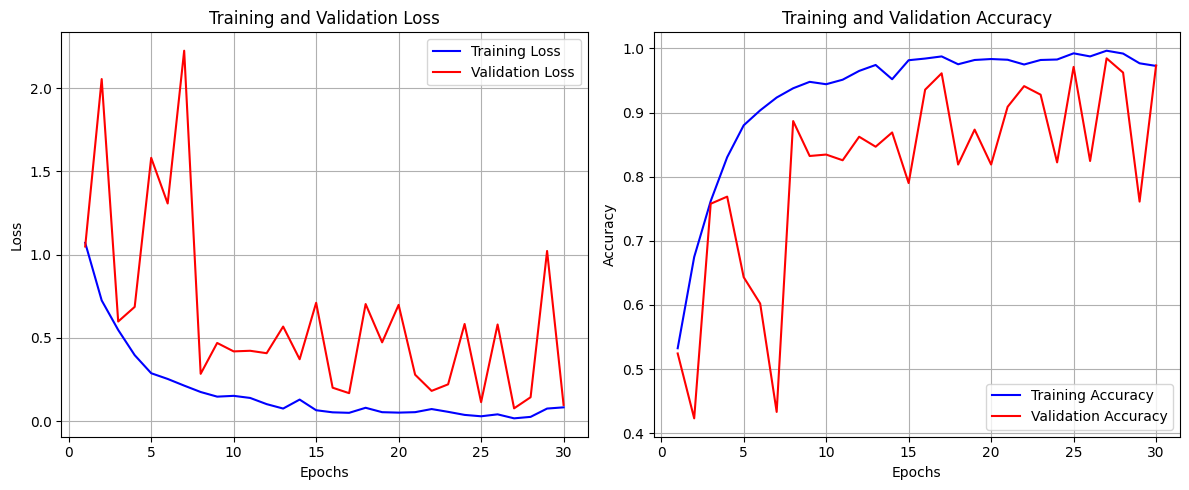


Evaluating model on test set:

Classification Report:
              precision    recall  f1-score   support

     Class_0       0.94      0.93      0.94       157
     Class_1       0.93      0.94      0.94       154
     Class_2       1.00      1.00      1.00       135
     Class_3       0.98      1.00      0.99       160
     Class_4       1.00      0.96      0.98       141
     Class_5       0.98      0.99      0.99       153

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



<Figure size 640x480 with 0 Axes>

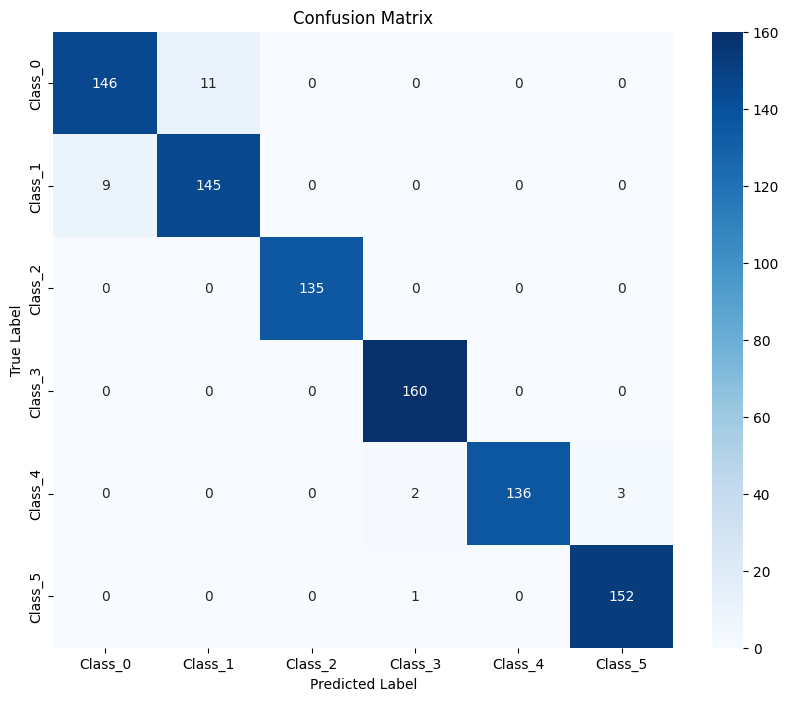

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class CSIDataset(Dataset):
    def __init__(self, signals, labels):
        """
        signals: numpy array of shape (N, 3, 30, 1500)
        labels: numpy array of shape (N,)
        """
        self.signals = torch.FloatTensor(signals)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out

class CSIResNet(nn.Module):
    def __init__(self, num_classes):
        super(CSIResNet, self).__init__()
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        
    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot training and validation metrics (loss and accuracy) over epochs
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Save the plots
    plt.savefig('training_metrics.png')

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            acc = predicted.eq(labels).sum().item() / labels.size(0)
            
            train_loss.update(loss.item(), inputs.size(0))
            train_acc.update(acc, inputs.size(0))
        
        # Validation phase
        val_loss, val_acc = test_model(model, val_loader, criterion, device)
        
        # Store metrics
        train_losses.append(train_loss.avg)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc.avg)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss.avg:.4f} Train Acc: {train_acc.avg*100:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc*100:.2f}%')
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    # Plot training metrics
    plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def test_model(model, test_loader, criterion, device):
    """
    Test the model and return loss and accuracy
    """
    model.eval()
    test_loss = AverageMeter()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss.update(loss.item(), inputs.size(0))
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    return test_loss.avg, accuracy

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot confusion matrix using seaborn
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()

def evaluate_model(model, test_loader, device, class_names):
    """
    Comprehensive model evaluation
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)

def main():
    # Hyperparameters
    num_classes = 6  
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 50
    
    # Device configuration
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f'Using device: {device}')
        
    # Create dataset and dataloader
    # Split the data into train validation and test sets
    X_train, X_test, y_train, y_test = train_test_split(transposed_data, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Create datasets and dataloaders
    train_dataset = CSIDataset(X_train, y_train)
    test_dataset = CSIDataset(X_test, y_test)
    val_dataset = CSIDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model, criterion, and optimizer
    model = CSIResNet(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Class names (replace with your actual class names)
    class_names = [f'Class_{i}' for i in range(num_classes)]

    # Train the model and get metrics
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, num_epochs
    )
    
    # Save the final model
    torch.save(model.state_dict(), 'csi_resnet_model.pth')

    # Evaluate model
    print("\nEvaluating model on test set:")
    evaluate_model(model, test_loader, device, class_names)

if __name__ == '__main__':
    print("filtered CSI data ....")
    transposed_data = processed_data_butterworth
    main()